## Data Preprocessing

In [7]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

### Data Loading and Cleaning

In [ ]:
# start_month: 1-12
def download_data(start_year, start_month=1, path = 'Data'):
  start_month = start_month - 1

  months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
  start_year = 2017 if start_year < 2017 else start_year # limiting to 2017 because they had different data structures before that
  end_year = 2023
  end_month = 3
  data_frames = []

  for i in range(12 * (end_year - start_year) + end_month - start_month):
    month = months[(i + start_month) % 12]
    year = int(start_year + (i + start_month) / 12)
    
    #Use below for google colab
    '''
    !echo http://s3.amazonaws.com/tripdata/$year$month-citibike-tripdata.csv.zip
    !wget -q http://s3.amazonaws.com/tripdata/$year$month-citibike-tripdata.csv.zip
    !unzip -o $year$month-citibike-tripdata.csv.zip
    # for some reason these downloads fail, we can upload the data manually
    if not (year == 2022 and month == "06") and not (year == 2022 and month == "07"):
      data_frames.append(pd.read_csv("{}{}-citibike-tripdata.csv".format(year, month)))
    '''
    #Use below for not google colab (must download and extract csv files into folder specified by path parameter)
    data_frames.append(pd.read_csv(path + "\{}{}-citibike-tripdata.csv".format(year, month)))
  
  final_df = pd.concat(data_frames, axis=0, ignore_index=True)
  data_frames = []
  final_df.dropna(inplace=True) # drop NaN
  final_df = final_df.sort_values(by="started_at") # sort by start time

  return final_df

data = download_data(2023, 1)
data.head() # we will split train/test data later

In [9]:
len(data)

5786048

### Data Preprocessing- Mundane Stuff


In [10]:
data['start_station_id'].values

array([6955.01, '7634.01', '5267.08', ..., 7511.19, 7372.1, 6280.12],
      dtype=object)

In [11]:

#This code does not take into account if there are some end stations that are not in start stations
# Reassign the station id to a standard #
locations = data['start_station_id'].unique()
new_ids = list(range(len(data['start_station_id'].unique())))
mapping = dict(zip(locations, new_ids))

data['start_station_id'] = data['start_station_id'].map(mapping)
data['end_station_id'] = data['end_station_id'].map(mapping)

'''
#Reassigns station id to a standard #, taking to account if there are some end stations not in start stations and vice verso
all_location_ids = np.concatenate((data['start_station_id'].values, data['end_station_id']), axis=0).astype(str)
all_location_ids = np.unique(all_location_ids)
new_ids = list(range(len(all_location_ids)))
mapping = dict(zip(all_location_ids, new_ids))

data['start_station_id'] = data['start_station_id'].astype(str).map(mapping)
data['end_station_id'] = data['end_station_id'].astype(str).map(mapping)
'''

"\n#Reassigns station id to a standard #, taking to account if there are some end stations not in start stations and vice verso\nall_location_ids = np.concatenate((data['start_station_id'].values, data['end_station_id']), axis=0).astype(str)\nall_location_ids = np.unique(all_location_ids)\nnew_ids = list(range(len(all_location_ids)))\nmapping = dict(zip(all_location_ids, new_ids))\n\ndata['start_station_id'] = data['start_station_id'].astype(str).map(mapping)\ndata['end_station_id'] = data['end_station_id'].astype(str).map(mapping)\n"

In [12]:
data[data.isna().any(axis=1)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
509157,636C34990A33F57C,electric_bike,2023-01-01 04:33:23,2023-01-01 05:30:29,Allen St & Stanton St,252,Lafayette Park,NaN,40.722055,-73.989111,40.713464,-74.062859,casual
1726989,4DD951937B2DC1E4,classic_bike,2023-01-01 06:50:31,2023-01-01 07:12:59,Lincoln Pl & Nostrand Ave,485,Pier 40 Dock Station,NaN,40.670704,-73.950649,40.728660,-74.011980,member
1731836,C147E61B256816F2,classic_bike,2023-01-02 06:27:29,2023-01-02 06:33:48,Vesey St & Church St,1972,Pier 40 Dock Station,NaN,40.712196,-74.010544,40.728660,-74.011980,casual
706989,91D92EA3A36C7D7D,classic_bike,2023-01-02 07:07:03,2023-01-02 07:13:30,Hudson St & Reade St,709,Pier 40 Dock Station,NaN,40.716253,-74.009220,40.728660,-74.011980,casual
282851,0338F3A873C6CAE9,classic_bike,2023-01-02 15:34:03,2023-01-02 16:39:45,Cabrini Blvd & W 177 St,2827,Bloomfield St & 15 St,NaN,40.848282,-73.941343,40.754530,-74.026580,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5256465,38D37DDB44C2E92C,classic_bike,2023-03-31 23:51:46,2023-04-01 00:17:06,Norfolk St & Broome St,926,N 5 St & Northside Piers,NaN,40.717227,-73.988021,40.720000,-73.960000,casual
5256482,F274040891724C87,classic_bike,2023-03-31 23:52:26,2023-04-01 00:16:57,Norfolk St & Broome St,926,N 5 St & Northside Piers,NaN,40.717227,-73.988021,40.720000,-73.960000,member
4734215,6D1BF016F8A998E7,classic_bike,2023-03-31 23:55:57,2023-03-31 23:58:35,Kent St & McGuinness Blvd,127,N Henry St & Norman Ave,NaN,40.731264,-73.951538,40.730000,-73.940000,member
4348934,61ED48008D685781,classic_bike,2023-03-31 23:57:22,2023-04-01 00:08:20,Waterbury St & Stagg St,12,S 4 St & Roebling St,NaN,40.710190,-73.937340,40.710000,-73.960000,casual


In [13]:
data = data.dropna()

In [14]:
data[data.isna().any(axis=1)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual


In [15]:
# convert strings into date objects
data["started_at"] = pd.to_datetime(data["started_at"], format="%Y-%m-%d %H:%M:%S")
data["ended_at"] = pd.to_datetime(data["ended_at"], format="%Y-%m-%d %H:%M:%S")

# calculate strip duration in seconds
data['trip_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds()

data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
879593,4612E3DBB1F3088D,classic_bike,2023-01-01 00:00:13,2023-01-01 00:19:55,W 56 St & 10 Ave,0,Harrison St & Hudson St,704.0,40.768355,-73.988888,40.718710,-74.009001,member,1182.0
319265,4C882B46547FA011,classic_bike,2023-01-01 00:00:15,2023-01-01 00:35:07,W 106 St & Amsterdam Ave,1,W 106 St & Amsterdam Ave,1.0,40.800795,-73.966422,40.800836,-73.966449,member,2092.0
700568,63AF84DBE457A618,classic_bike,2023-01-01 00:00:21,2023-01-01 00:01:14,Grand St & Havemeyer St,2,Grand St & Havemeyer St,2.0,40.712868,-73.956981,40.712868,-73.956981,casual,53.0
1263783,2054AE257784A52C,classic_bike,2023-01-01 00:00:27,2023-01-01 00:06:50,President St & Henry St,3,Clinton St & 4 Place,2484.0,40.682745,-73.999806,40.678356,-74.000145,member,383.0
131250,D853DABC874C9655,classic_bike,2023-01-01 00:00:29,2023-01-01 00:02:37,Nagle Ave & Ellwood St,4,Nagle Ave & Ellwood St,3141.0,40.860120,-73.928489,40.860120,-73.928489,member,128.0


### Nodes


In [16]:
outgoing_trips = data.groupby("start_station_id").count()
incoming_trips = data.groupby("end_station_id").count()

In [17]:
print(incoming_trips.index[0:100])

Float64Index([  0.0,   1.0,   2.0,   3.0,   4.0,   5.0,   7.0,   8.0,   9.0,
               10.0,  11.0,  13.0,  15.0,  16.0,  17.0,  18.0,  19.0,  20.0,
               21.0,  22.0,  23.0,  24.0,  26.0,  27.0,  28.0,  29.0,  30.0,
               31.0,  32.0,  33.0,  34.0,  35.0,  36.0,  37.0,  38.0,  39.0,
               41.0,  42.0,  43.0,  44.0,  45.0,  46.0,  47.0,  48.0,  50.0,
               51.0,  52.0,  53.0,  54.0,  55.0,  56.0,  57.0,  58.0,  59.0,
               60.0,  61.0,  64.0,  65.0,  66.0,  67.0,  68.0,  69.0,  70.0,
               71.0,  72.0,  73.0,  74.0,  75.0,  76.0,  77.0,  78.0,  79.0,
               80.0,  81.0,  82.0,  83.0,  84.0,  85.0,  86.0,  87.0,  88.0,
               89.0,  90.0,  91.0,  92.0,  93.0,  94.0,  95.0,  96.0,  97.0,
               99.0, 100.0, 101.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0,
              109.0],
             dtype='float64', name='end_station_id')


In [18]:
print(data.groupby("start_station_id").count())

                  ride_id  rideable_type  started_at  ended_at  \
start_station_id                                                 
0                    6429           6429        6429      6429   
1                    1045           1045        1045      1045   
2                     901            901         901       901   
3                     469            469         469       469   
4                     638            638         638       638   
...                   ...            ...         ...       ...   
3595                  161            161         161       161   
3596                   23             23          23        23   
3597                   15             15          15        15   
3598                   11             11          11        11   
3599                   22             22          22        22   

                  start_station_name  end_station_name  end_station_id  \
start_station_id                                                   

In [19]:
import numpy as np
# Find out how many outgoing bikers we have
outgoing_trips = data.groupby("start_station_id").count()
incoming_trips = data.groupby("end_station_id").count()

# Match the list sizes
actual_incoming_trips = []
for idx in outgoing_trips.index:
  if idx not in incoming_trips.index:
    actual_incoming_trips.append(0)
  else:
    actual_incoming_trips.append(incoming_trips.loc[[idx]]['ride_id'].values[0])

actual_incoming_trips = np.asarray(actual_incoming_trips)
incoming_trips = actual_incoming_trips
outgoing_trips = outgoing_trips['ride_id'].values

# Normalize features between 0 and 1
outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features[0:5]

Full shape:  (3600, 2)


array([[0.29320805, 0.05852484],
       [0.04762122, 0.13762236],
       [0.04105278, 0.23593153],
       [0.02134744, 0.10521908],
       [0.02905624, 0.00266974]])

### Edges


In [20]:
cols = ["start_lng", "start_lat", "end_lng", "end_lat", "start_station_id", "end_station_id"]
station_pairs = data.drop_duplicates(subset=["start_station_id", "end_station_id" ], keep="first")[cols]
station_pairs["distance"] = station_pairs.apply(lambda x: geodesic((x["start_lat"], x["start_lng"]), (x["end_lat"], x["end_lng"])).meters, axis=1)
station_pairs.to_csv("Data\station_pairs2023-1-3only.csv")
#station_pairs = pd.read_csv("Data\station_pairs2023-1-3only.csv")


In [21]:
station_pairs["edge"] = station_pairs["distance"] < 150 # we will only consider edges less than 300 meters to limit the complexity of the model
station_pairs

,start_lng,start_lat,end_lng,end_lat,start_station_id,end_station_id,distance,edge
879593,-73.988888,40.768355,-74.009001,40.718710,0,704.0,5768.818851,False
319265,-73.966422,40.800795,-73.966449,40.800836,1,1.0,5.145050,True
700568,-73.956981,40.712868,-73.956981,40.712868,2,2.0,0.000000,True
1263783,-73.999806,40.682745,-74.000145,40.678356,3,2484.0,488.140135,False
131250,-73.928489,40.860120,-73.928489,40.860120,4,3141.0,0.000000,True
...,...,...,...,...,...,...,...,...
3744559,-73.953990,40.682166,-73.907420,40.700680,813,1336.0,4440.992549,False
4762928,-73.930331,40.701137,-73.915720,40.713340,125,3422.0,1833.284192,False
3870499,-73.991026,40.730207,-73.965903,40.712859,995,308.0,2866.482711,False
5112800,-73.994822,40.750489,-73.956156,40.819034,927,384.0,8282.105109,False


In [22]:
edge_index = station_pairs[station_pairs["edge"] == True][["start_station_id", "end_station_id"]].values
edge_index = edge_index.transpose()
print(edge_index.size)
edge_index

9284


array([[1.000e+00, 2.000e+00, 4.000e+00, ..., 3.597e+03, 3.594e+03,
        3.594e+03],
       [1.000e+00, 2.000e+00, 3.141e+03, ..., 3.597e+03, 3.594e+03,
        3.591e+03]])

In [23]:
print(np.shape(edge_index))
print(np.min(edge_index))
print(np.max(edge_index))

(2, 4642)
0.0
3597.0


In [24]:
len(edge_index.T[np.isnan(edge_index.T).any(axis=1)])

0

In [25]:
edge_features = station_pairs[station_pairs["edge"] == True]["distance"].values
#edge_features

In [26]:
from pandas._libs.tslibs.offsets import YearOffset
start_date = data.iloc[0]['started_at']
end_date = data.iloc[-1]['started_at']
interval = timedelta(hours=3)


labels = []

#stop = start_date + timedelta(hours=24)
#while start_date <= stop:
while start_date <= end_date:
    
    current_snapshot = data[((start_date + interval) >= data["ended_at"]) & (start_date <= data["ended_at"])]
    
    # Compute average duration of trips along the same edge
    current_snapshot = current_snapshot.groupby(["start_station_id", "end_station_id"]).mean().reset_index()
    
    # Labels as the number of outgoing trips from each station within this hour
    start_stations = np.zeros_like(data["start_station_id"].unique())

    y = current_snapshot.groupby("start_station_id").count()['start_lat'].values
    y_index = np.unique(current_snapshot[["start_station_id"]].values.transpose())

    
    start_stations[y_index] = y
    labels.append(start_stations)

    start_date += interval


In [27]:
print(len(labels))
i = 9
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {node_features.shape} \n
      Edge index shape: {edge_index.shape} \n
      Edge feature shape: {edge_features.shape} \n 
      Labels shape: {labels[i].shape} \n
      """)

720
Example of graph snapshot 9: 

      Node feature shape: (3600, 2) 

      Edge index shape: (2, 4642) 

      Edge feature shape: (4642,) 
 
      Labels shape: (3600,) 

      


In [28]:
labels[9][100:200]

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int64)

### Sliding Window to Map Labels (Features) to Labels (Targets)

In [29]:
outgoing = np.array(labels)

outgoing[i][j] is an array that contains the number of outgoing trips from the jth station in the ith timestep

outgoing is our feature and our target, if we use 5 timesteps to predict the next 5 steps, then 
outgoing[i-5:i][:] would be our x, and outgoing[i:i + 5][:] would be our y.
We use a sliding window to construct our x and y from outgoing


In [30]:
np.shape(outgoing)

(720, 3600)

In [31]:
np.shape(np.sum(outgoing, axis=1))

(720,)

<AxesSubplot:xlabel='index', ylabel='trips_per_hour'>

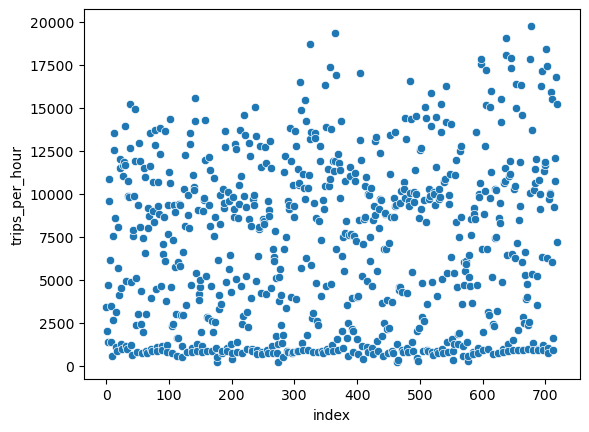

In [32]:
import seaborn as sns
sns.scatterplot(x="index", y="trips_per_hour", data=pd.DataFrame(np.sum(outgoing, axis = 1), columns=["trips_per_hour"]).reset_index())

(array([182.,  70.,  71.,  58., 120., 100.,  59.,  33.,  18.,   9.]),
 array([  237.,  2188.,  4139.,  6090.,  8041.,  9992., 11943., 13894.,
        15845., 17796., 19747.]),
 <BarContainer object of 10 artists>)

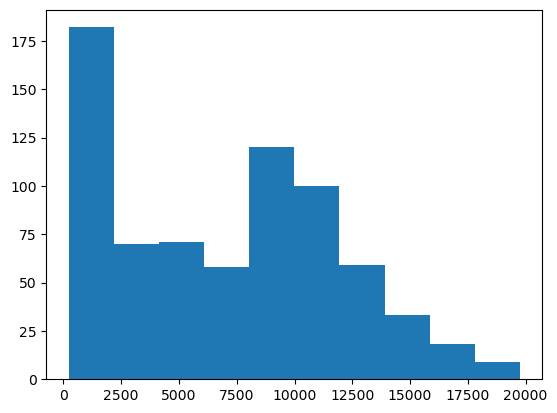

In [33]:
import matplotlib.pyplot as plt
plt.hist(np.sum(outgoing, axis = 1))

(array([182.,  70.,  71.,  58., 120., 101.,  58.,  33.,  18.,   9.]),
 array([0.06583333, 0.60777778, 1.14972222, 1.69166667, 2.23361111,
        2.77555556, 3.3175    , 3.85944444, 4.40138889, 4.94333333,
        5.48527778]),
 <BarContainer object of 10 artists>)

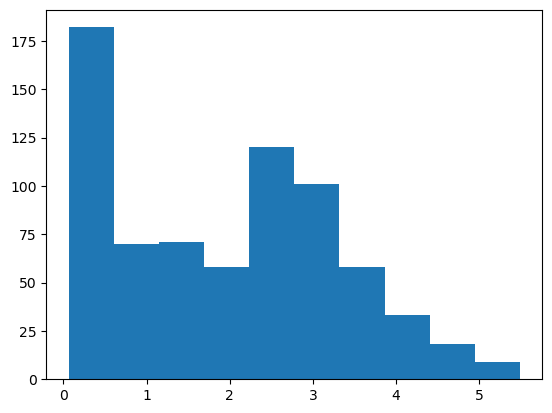

In [34]:
plt.hist(np.average(outgoing, axis=1))

In [35]:
np.max(edge_index)

3597.0

In [36]:
from typing import Tuple
import math
#need to create features np array and targets np array
#using sliding window
#parameters time_steps_in and time_steps_out
#should use 24 hours for proof of concept
def sliding_window(data: np.array, timestep_in: int, timestep_out: int, overlap = True) -> Tuple[np.array, np.array]:
    if(overlap):
        n = len(data)
        if(timestep_in + timestep_out > len(data)):
            print("Timestep sizes (" + str(timestep_in) + ", " + str(timestep_out) + ") are too large for data length: " + str(n))
        else:
            x = np.array([data[i: i + timestep_in] for i in range(n - timestep_in - timestep_out + 1)])
            y = np.array([data[i: i + timestep_out] for i in range(timestep_in, n - timestep_out + 1)])
            return(x, y)
    else:
        n = len(data)
        if(timestep_in + timestep_out > len(data)):
            print("Timestep sizes (" + str(timestep_in) + ", " + str(timestep_out) + ") are too large for data length: " + str(n))
        else:
            total = np.array([data[i: i + timestep_in + timestep_out] for i in range(0, n - timestep_in + 1, timestep_out + timestep_in)])
            x = np.array([arr[0:timestep_in] for arr in total])
            y = np.array([arr[timestep_in:] for arr in total])
            return(x, y)

x, y = sliding_window(np.arange(24), 4, 2, False)
print(len(x) == len(y))
for i in range(len(x)):
    print(str(x[i]) + "  :      " + str(y[i]))

True
[0 1 2 3]  :      [4 5]
[6 7 8 9]  :      [10 11]
[12 13 14 15]  :      [16 17]
[18 19 20 21]  :      [22 23]


In [37]:
x, y = sliding_window(outgoing, 12, 1, False)
#reshaping x and y for temporal graph neural network
x = np.expand_dims(np.transpose(x, (0, 2, 1)), axis = 2)
y = np.transpose(y, (0, 2, 1))
print("Shape of x: " + str(np.shape(x)))
print("Shape of y: " + str(np.shape(y)))

Shape of x: (55, 3600, 1, 12)
Shape of y: (55, 3600, 1)


## Creating Basic Graph Neural Network

### Creating Graph Objects

#### Creating First Graph Object

In [38]:
import torch
import torch_geometric
import torch_geometric_temporal
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric_temporal import StaticGraphTemporalSignal

In [39]:
temporal_dataset = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=edge_features, features=x, targets=y)

In [40]:
print(temporal_dataset[0])

Data(x=[3600, 1, 12], edge_index=[2, 4642], edge_attr=[4642], y=[3600, 1])


In [41]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(temporal_dataset, train_ratio=0.8)

#print("Number of train buckets: ", len(set(train_dataset)))
#print("Number of test buckets: ", len(set(test_dataset)))

In [42]:
type(train_dataset)

torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal

In [43]:
train_dataset.snapshot_count

44

In [44]:
next(iter(train_dataset))

Data(x=[3600, 1, 12], edge_index=[2, 4642], edge_attr=[4642], y=[3600, 1])

In [45]:
np.shape(x)

(55, 3600, 1, 12)

In [46]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods_in, periods_out):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods_in)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods_out)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=1, periods_in=12, periods_out = 1)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [47]:
# GPU support
device = torch.device('cpu') # cuda
subset = 100 #can modify subset when running into memory bottlenecks

# Create model and optimizers
model = TemporalGNN(node_features=1, periods_in=12, periods_out=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

training_mses = []
testing_mses = []

#used https://www.youtube.com/watch?v=Rws9mf1aWUs to help with temporal GNN syntax and implementation

print("Running training...")
for epoch in range(50): 
    loss = 0
    step = 0
    snapshot_count = train_dataset.snapshot_count
    if(snapshot_count > subset):
      skip = 0
      for snapshot in train_dataset:
        if skip < snapshot_count - subset:
          skip += 1
        else:
          #print(step)
          snapshot = snapshot.to(device)
          # Get model predictions
          y_hat = model(snapshot.x, snapshot.edge_index)
          # Mean squared error
          loss = loss + torch.mean((y_hat-snapshot.y)**2) 
          step += 1
    else:
      for snapshot in train_dataset:
          #print(step)
          snapshot = snapshot.to(device)
          # Get model predictions
          y_hat = model(snapshot.x, snapshot.edge_index)
          # Mean squared error
          loss = loss + torch.mean((y_hat-snapshot.y)**2) 
          step += 1
          if step > subset:
            break

    loss = loss / (step + 1)
    training_mses.append(loss.item())
    model.eval()
    with torch.no_grad():
      testing_loss = 0
      testing_step = 0
      for snapshot in test_dataset:
        y_hat = model(snapshot.x, snapshot.edge_index)
        testing_loss = testing_loss + torch.mean((y_hat-snapshot.y)**2)
        testing_step += 1
      testing_loss = testing_loss / (testing_step + 1)
      testing_mses.append(testing_loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))
    print("Epoch {} test MSE: {:.4f}".format(epoch, testing_loss.item()))

Running training...
Epoch 0 train MSE: 19.2814
Epoch 0 test MSE: 38.5096
Epoch 1 train MSE: 18.3663
Epoch 1 test MSE: 37.3636
Epoch 2 train MSE: 17.7514
Epoch 2 test MSE: 36.6429
Epoch 3 train MSE: 17.1861
Epoch 3 test MSE: 35.9845
Epoch 4 train MSE: 16.6306
Epoch 4 test MSE: 35.3346
Epoch 5 train MSE: 16.1277
Epoch 5 test MSE: 34.7778
Epoch 6 train MSE: 15.6779
Epoch 6 test MSE: 34.2948
Epoch 7 train MSE: 15.2686
Epoch 7 test MSE: 33.8527
Epoch 8 train MSE: 14.8936
Epoch 8 test MSE: 33.4409
Epoch 9 train MSE: 14.5585
Epoch 9 test MSE: 33.0773
Epoch 10 train MSE: 14.2659
Epoch 10 test MSE: 32.7615
Epoch 11 train MSE: 14.0155
Epoch 11 test MSE: 32.4887
Epoch 12 train MSE: 13.8063
Epoch 12 test MSE: 32.2563
Epoch 13 train MSE: 13.6374
Epoch 13 test MSE: 32.0626
Epoch 14 train MSE: 13.5058
Epoch 14 test MSE: 31.9046
Epoch 15 train MSE: 13.4057
Epoch 15 test MSE: 31.7772
Epoch 16 train MSE: 13.3288
Epoch 16 test MSE: 31.6729
Epoch 17 train MSE: 13.2658
Epoch 17 test MSE: 31.5836
Epoch 18 t

In [48]:
model.eval()
loss = 0
step = 0
horizon = 12

# Store for analysis
predictions = []
labels = []

#used https://www.youtube.com/watch?v=Rws9mf1aWUs to help with temporal GNN syntax and implementation

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    #if step > horizon:
    #      break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 27.9574


In [49]:
np.shape(outgoing[0])

(3600,)

<AxesSubplot:title={'center':'Training and Testing Loss'}, xlabel='Epoch', ylabel='Mean Squared Error'>

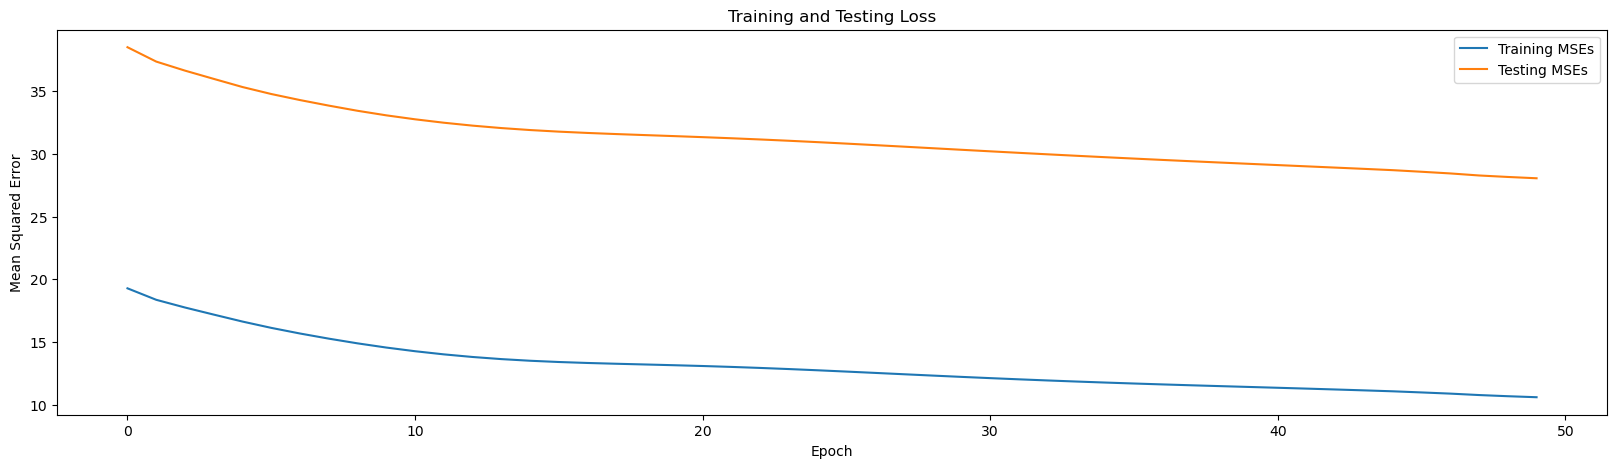

In [50]:
plt.figure(figsize=(20,5))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training and Testing Loss")

sns.lineplot(data=training_mses, label="Training MSEs")
sns.lineplot(data=testing_mses, label="Testing MSEs")

In [51]:
loss_tuples = list(zip(training_mses, testing_mses))
loss_df = pd.DataFrame(loss_tuples, columns=["Training MSE", "Testing MSE"])
loss_df.to_csv("Data/losses_all_2023_3_12_1.csv")

Data points:, (11,)


<AxesSubplot:>

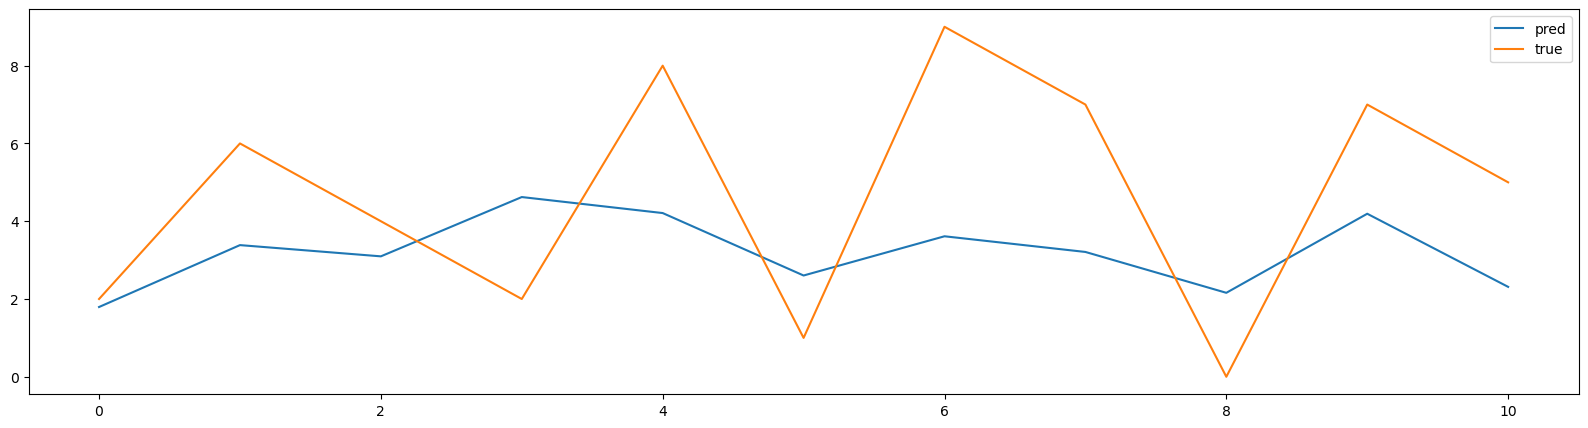

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns 

sensor = np.argmax(np.sum(outgoing, axis=1))
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")